In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf


#티스토리 업로드시 최적화 코드
#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:90% !important;}</style>"))

# 2023.04.17
# TRAINING
Dataset Info.

train.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사
    Book-Rating : 유저가 도서에 부여한 평점 (0점 ~ 10점)


test.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사


sample_submission.csv [제출양식]

    ID : 샘플 고유 ID
    Book-Rating : 예측한 유저가 도서에 부여할 평점

In [2]:
import pandas as pd

In [3]:
import numpy as np
import random
import os
import gc

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv( 'test.csv')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

In [6]:
train['City'] = [(i.split(',')[0]).lstrip().title() for i in train['Location']]
train['State'] = [(i.split(',')[1]).lstrip().title() for i in train['Location']]
train['Country'] = [(i.split(',')[2]).lstrip().title() for i in train['Location']]

In [7]:
test['City'] = [(i.split(',')[0]).lstrip().title() for i in test['Location']]
test['State'] = [(i.split(',')[1]).lstrip().title() for i in test['Location']]
test['Country'] = [(i.split(',')[2]).lstrip().title() for i in test['Location']]

In [37]:
!pip install imbalanced-learn

In [8]:
def preprocessing_data(df):
    # Decompose Location by split
    df['City'] = [(i.split(',')[0]).lstrip().title() for i in df['Location']]
    df['State'] = [(i.split(',')[1]).lstrip().title() for i in df['Location']]
    df['Country'] = [(i.split(',')[2]).lstrip().title() for i in df['Location']]
    
    # NaN, N/A, etc.. Delete and Change
    # Only using Train Data
    df_pp = train.copy()[['ID', 'User-ID','City', 'State','Country']]
    
    # test preprocessing
    df['City_st'] = df['City'].apply(preprocessing_location)
    df['State_st'] = df['State'].apply(preprocessing_location)
    df['Country_st'] = df['Country'].apply(preprocessing_location)
    
    df_pp['City_st'] = df_pp['City'].apply(preprocessing_location)
    df_pp['State_st'] = df_pp['State'].apply(preprocessing_location)
    df_pp['Country_st'] = df_pp['Country'].apply(preprocessing_location)

    df_pp = df_pp[(df_pp['City_st'].astype(str) != '') & (df_pp['City_st'].astype(str) != 'N/A') & (df_pp['State_st'].astype(str) != '') & (df_pp['State_st'].astype(str) != 'N/A')]
    
    country_ct = df_pp.groupby(['State_st','Country_st'],as_index=True)['Country_st'].count().sort_values().groupby(level=0).tail(1)
    country_ct = pd.DataFrame(country_ct)
    country_ct = country_ct.rename(columns={'Country_st':'count'})
    country_ct = country_ct.reset_index()
    new_country = country_ct[country_ct['count'] >= 10]
    new_country.columns = ['State_st', 'N_Country', 'count']
    
    df_N = pd.merge(df, new_country[['State_st', 'N_Country']], on = 'State_st', how = 'left')
    
    df_N['N_Country'] = np.where((df_N['N_Country'] == '')|(df_N['N_Country'].astype(str) == 'nan'), 
                                 np.where((df_N['Country_st'] == '')|(df_N['Country_st'].astype(str) == 'nan'), 'UnKnown', df_N['Country_st']), df_N['N_Country'])
    

    # train에 있는 정보로 County 바꾸기
    df_N.loc[df_N['State_st'] == 'michigan usa', 'N_Country'] = 'usa'
    df_N.loc[df_N['State_st'] == 'wicklow', 'N_Country'] = 'ireland'
    df_N.loc[df_N['State_st'] == 'ilfov', 'N_Country'] = ''
    df_N.loc[df_N['State_st'] == 'liege', 'N_Country'] = 'belgium'
    df_N.loc[df_N['State_st'] == 'estremadura', 'N_Country'] = 'portugal'
    df_N.loc[df_N['State_st'] == 'aberdeenshire', 'N_Country'] = 'united kingdom'
    df_N.loc[df_N['State_st'] == 'wi', 'N_Country'] = 'wisconsin'
    
    return df_N
    

In [21]:
N_train = preprocessing_data(train)
N_test = preprocessing_data(test)
N_train

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country,City_st,State_st,Country_st,N_Country
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira,Sackville,New Brunswick,Canada,sackville,new brunswick,canada,canada
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books,Sackville,New Brunswick,Canada,sackville,new brunswick,canada,canada
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books,Sackville,New Brunswick,Canada,sackville,new brunswick,canada,canada
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon,Sackville,New Brunswick,Canada,sackville,new brunswick,canada,canada
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book,Sackville,New Brunswick,Canada,sackville,new brunswick,canada,canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871388,TRAIN_871388,USER_92096,BOOK_081138,0,34.0,"minneapolis, minnesota, usa",Healing Words: The Power of Prayer and the Pra...,Larry Dossey,1993.0,Harpercollins,Minneapolis,Minnesota,Usa,minneapolis,minnesota,usa,usa
871389,TRAIN_871389,USER_92097,BOOK_258124,0,35.0,"temple, texas, usa",The Salmon of Doubt: Hitchhiking the Galaxy On...,DOUGLAS ADAMS,2002.0,Harmony,Temple,Texas,Usa,temple,texas,usa,usa
871390,TRAIN_871390,USER_92098,BOOK_071848,0,45.0,"ottawa, ontario, canada",Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2000.0,Thorndike Press,Ottawa,Ontario,Canada,ottawa,ontario,canada,canada
871391,TRAIN_871391,USER_92099,BOOK_252599,8,43.0,"maple grove, minnesota, usa",Heartbreak Hill: Anatomy of a Ryder Cup,Tim Rosaforte,1996.0,St Martins Pr,Maple Grove,Minnesota,Usa,maple grove,minnesota,usa,usa


In [ ]:
!pip install catboost

In [9]:
# 나이 그룹화
labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]
#N_train['Age_gb'] = pd.cut(N_train.Age, bins, labels = labels,include_lowest = True)
train['Age_gb'] = pd.cut(train.Age, bins, labels = labels,include_lowest = True)

In [10]:
#N_test['Age_gb'] = pd.cut(N_test.Age, bins, labels = labels,include_lowest = True)
test['Age_gb'] = pd.cut(test.Age, bins, labels = labels,include_lowest = True)

In [9]:
def feature_engineering(df):
    labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
    bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]
    df['Age_gb'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)
    df = df.join(
                df.groupby('Country')['Age'].aggregate(['median',  'mean']), #'mean', pd.Series.mode
                on='Country'
                )
    return df

In [11]:
from sklearn.preprocessing import OrdinalEncoder

#N_FEATURES = ['ID', 'User-ID', 'Book-Rating', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'City','State_st','N_Country']
#N_FEATURES_T = ['ID', 'User-ID', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'City','State','N_Country','Age_gb']
FEATURE = ['User-ID', 'Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#,'Topic_num']

train_lb = train.__deepcopy__() 
test_lb = test.__deepcopy__()

#train_lb = feature_engineering(train_lb)
#test_lb = feature_engineering(test_lb)

#train_lb = pd.merge(train_lb, title, on = 'Book-Title_st', how = 'left')
#test_lb = pd.merge(test_lb, title_t, on = 'Book-Title_st', how = 'left')

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str) 
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

for i in FEATURE:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    oe=oe.fit(train_lb[i].to_numpy().reshape(-1, 1))
    train_lb[i] = oe.transform(train_lb[i].to_numpy().reshape(-1, 1))
    test_lb[i] = oe.transform(test_lb[i].to_numpy().reshape(-1, 1))

In [54]:
X_train = train_lb.drop(columns = ['ID','Book-Rating'])
y_train = train_lb['Book-Rating']
x_test = test_lb.drop(columns = ['ID'])

In [67]:
list(set(X_train.columns) - set(FEATURE))

['Age', 'Year-Of-Publication']

In [68]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()    # create an object of class

scaler_FEATURE = list(set(X_train.columns) - set(FEATURE))
scaler.fit(X_train[scaler_FEATURE])       #  fit on training i/p data

X_train[scaler_FEATURE] = scaler.transform(X_train[scaler_FEATURE])    # transform model on both traing and testing data
x_test[scaler_FEATURE] = scaler.transform(x_test[scaler_FEATURE])

<Figure size 400x400 with 0 Axes>

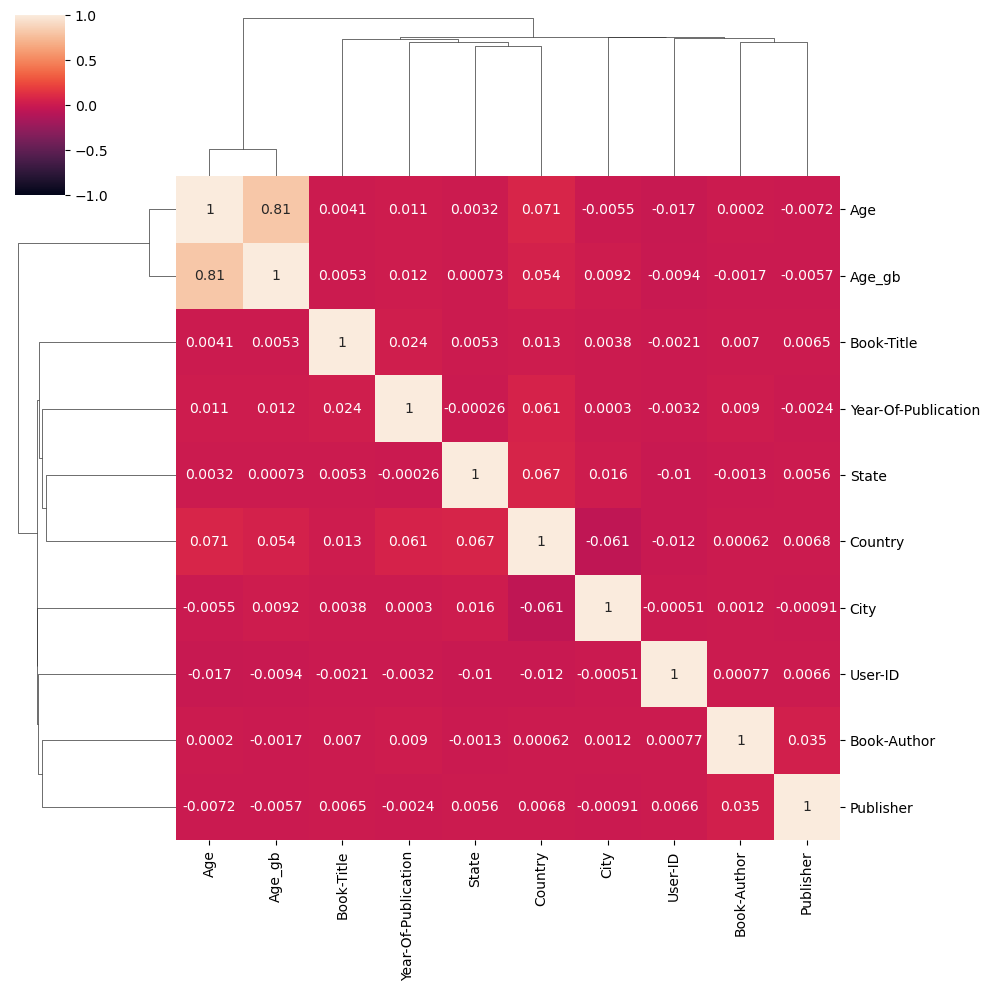

In [46]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize = (4, 4))
clustermap = sns.clustermap(x_train_scaled.corr(), vmin = -1, vmax = 1, annot = True)

In [72]:
from catboost import CatBoostRegressor 

model = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          eval_metric = 'RMSE',
                          iterations = 8694,
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          early_stopping_rounds = 100,
                          verbose=500
                          )

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  0
0:	learn: 3.8400301	test: 3.8396270	best: 3.8396270 (0)	total: 129ms	remaining: 18m 44s
500:	learn: 3.3160830	test: 3.2876170	best: 3.2876170 (500)	total: 1m 29s	remaining: 24m 20s
1000:	learn: 3.2730733	test: 3.2685398	best: 3.2685398 (1000)	total: 2m 50s	remaining: 21m 51s
1500:	learn: 3.2429467	test: 3.2607756	best: 3.2607729 (1498)	total: 4m 32s	remaining: 21m 46s
2000:	learn: 3.2173120	test: 3.2566708	best: 3.2566708 (2000)	total: 6m 17s	remaining: 21m 2s
2500:	learn: 3.1934941	test: 3.2535543	best: 3.2535543 (2500)	total: 8m 1s	remaining: 19m 53s
3000:	learn: 3.1707710	test: 3.2513150	best: 3.2513107 (2999)	total: 9m 42s	remaining: 18m 24s
3500:	learn: 3.1487164	test: 3.2498653	best: 3.2498545 (3492)	total: 11m 17s	remaining: 16m 44s
4000:	learn: 3.1275898	test: 3.2488335	best: 3.2488335 (4000)	total: 12m 42s	remaining: 14m 54s
4500:	learn: 3.1067045	test: 3.2481076	best: 3.2480877 (4490)	total: 14m 18s	remaining: 13m 19s
5000:	learn: 3.0861572	test: 3.2475153	best: 3.24

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  1
0:	learn: 3.8399505	test: 3.8395751	best: 3.8395751 (0)	total: 188ms	remaining: 27m 11s
500:	learn: 3.3165660	test: 3.2778488	best: 3.2778488 (500)	total: 1m 21s	remaining: 22m 9s
1000:	learn: 3.2741111	test: 3.2582129	best: 3.2582129 (1000)	total: 2m 48s	remaining: 21m 31s
1500:	learn: 3.2434650	test: 3.2504534	best: 3.2504534 (1500)	total: 4m 11s	remaining: 20m 6s
2000:	learn: 3.2180092	test: 3.2462362	best: 3.2462362 (2000)	total: 5m 41s	remaining: 19m 1s
2500:	learn: 3.1940095	test: 3.2429754	best: 3.2429733 (2499)	total: 7m 9s	remaining: 17m 43s
3000:	learn: 3.1707427	test: 3.2404869	best: 3.2404869 (3000)	total: 8m 35s	remaining: 16m 18s
3500:	learn: 3.1487212	test: 3.2389103	best: 3.2389072 (3490)	total: 10m 3s	remaining: 14m 54s
4000:	learn: 3.1272094	test: 3.2375267	best: 3.2375267 (4000)	total: 11m 33s	remaining: 13m 33s
4500:	learn: 3.1073353	test: 3.2367369	best: 3.2367369 (4500)	total: 12m 59s	remaining: 12m 5s
5000:	learn: 3.0871423	test: 3.2359611	best: 3.235947

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  2
0:	learn: 3.8400364	test: 3.8394754	best: 3.8394754 (0)	total: 242ms	remaining: 35m 8s
500:	learn: 3.3184614	test: 3.2691938	best: 3.2691938 (500)	total: 1m 26s	remaining: 23m 31s
1000:	learn: 3.2753769	test: 3.2485625	best: 3.2485625 (1000)	total: 3m 15s	remaining: 24m 59s
1500:	learn: 3.2441863	test: 3.2401571	best: 3.2401571 (1500)	total: 4m 54s	remaining: 23m 32s
2000:	learn: 3.2168885	test: 3.2356091	best: 3.2356091 (2000)	total: 6m 36s	remaining: 22m 6s
2500:	learn: 3.1920301	test: 3.2327010	best: 3.2327010 (2500)	total: 8m 16s	remaining: 20m 29s
3000:	learn: 3.1687981	test: 3.2308502	best: 3.2308502 (3000)	total: 9m 51s	remaining: 18m 42s
3500:	learn: 3.1464987	test: 3.2292245	best: 3.2292204 (3498)	total: 11m 38s	remaining: 17m 15s
4000:	learn: 3.1251856	test: 3.2281748	best: 3.2281654 (3995)	total: 13m 16s	remaining: 15m 34s
4500:	learn: 3.1045002	test: 3.2275640	best: 3.2275460 (4474)	total: 14m 55s	remaining: 13m 54s
5000:	learn: 3.0848834	test: 3.2269621	best: 3.22

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  3
0:	learn: 3.8400700	test: 3.8395549	best: 3.8395549 (0)	total: 153ms	remaining: 22m 7s
500:	learn: 3.3161037	test: 3.2747903	best: 3.2747903 (500)	total: 1m 40s	remaining: 27m 17s
1000:	learn: 3.2736728	test: 3.2567288	best: 3.2567288 (1000)	total: 3m 27s	remaining: 26m 36s
1500:	learn: 3.2430045	test: 3.2502029	best: 3.2502029 (1500)	total: 5m 9s	remaining: 24m 43s
2000:	learn: 3.2162703	test: 3.2461173	best: 3.2461173 (2000)	total: 6m 52s	remaining: 22m 59s
2500:	learn: 3.1917430	test: 3.2436061	best: 3.2436020 (2499)	total: 8m 39s	remaining: 21m 25s
3000:	learn: 3.1687801	test: 3.2416707	best: 3.2416609 (2998)	total: 10m 25s	remaining: 19m 47s
3500:	learn: 3.1462654	test: 3.2404981	best: 3.2404981 (3500)	total: 12m 4s	remaining: 17m 55s
4000:	learn: 3.1244001	test: 3.2395865	best: 3.2395854 (3956)	total: 13m 54s	remaining: 16m 19s
4500:	learn: 3.1038558	test: 3.2387678	best: 3.2387546 (4499)	total: 15m 43s	remaining: 14m 38s
5000:	learn: 3.0841123	test: 3.2381755	best: 3.23

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  4
0:	learn: 3.8400282	test: 3.8395975	best: 3.8395975 (0)	total: 346ms	remaining: 50m 5s
500:	learn: 3.3160198	test: 3.2842412	best: 3.2842412 (500)	total: 1m 35s	remaining: 26m 3s
1000:	learn: 3.2735661	test: 3.2652693	best: 3.2652693 (1000)	total: 3m 11s	remaining: 24m 32s
1500:	learn: 3.2427471	test: 3.2572652	best: 3.2572652 (1500)	total: 4m 58s	remaining: 23m 49s
2000:	learn: 3.2155679	test: 3.2529982	best: 3.2529975 (1999)	total: 6m 7s	remaining: 20m 28s
2500:	learn: 3.1911355	test: 3.2501268	best: 3.2501268 (2500)	total: 7m 6s	remaining: 17m 35s
3000:	learn: 3.1676576	test: 3.2480567	best: 3.2480475 (2998)	total: 8m 5s	remaining: 15m 21s
3500:	learn: 3.1462445	test: 3.2464872	best: 3.2464802 (3495)	total: 9m 4s	remaining: 13m 28s
4000:	learn: 3.1255201	test: 3.2452876	best: 3.2452678 (3990)	total: 10m 4s	remaining: 11m 48s
4500:	learn: 3.1054905	test: 3.2444447	best: 3.2444438 (4499)	total: 11m 3s	remaining: 10m 18s
5000:	learn: 3.0855787	test: 3.2438565	best: 3.2438548 (

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  5
0:	learn: 3.8400549	test: 3.8394115	best: 3.8394115 (0)	total: 107ms	remaining: 15m 26s
500:	learn: 3.3182428	test: 3.2715382	best: 3.2715382 (500)	total: 55.6s	remaining: 15m 9s
1000:	learn: 3.2755466	test: 3.2529948	best: 3.2529948 (1000)	total: 1m 52s	remaining: 14m 21s
1500:	learn: 3.2439774	test: 3.2452323	best: 3.2452323 (1500)	total: 2m 49s	remaining: 13m 32s
2000:	learn: 3.2177768	test: 3.2412250	best: 3.2412250 (2000)	total: 3m 47s	remaining: 12m 39s
2500:	learn: 3.1932564	test: 3.2378271	best: 3.2378271 (2500)	total: 4m 44s	remaining: 11m 44s
3000:	learn: 3.1699344	test: 3.2355119	best: 3.2355119 (3000)	total: 5m 38s	remaining: 10m 41s
3500:	learn: 3.1479385	test: 3.2337178	best: 3.2337174 (3499)	total: 6m 34s	remaining: 9m 45s
4000:	learn: 3.1264848	test: 3.2325122	best: 3.2325031 (3994)	total: 7m 35s	remaining: 8m 53s
4500:	learn: 3.1060008	test: 3.2313645	best: 3.2313645 (4500)	total: 8m 31s	remaining: 7m 56s
5000:	learn: 3.0857313	test: 3.2306172	best: 3.2305922 

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  6
0:	learn: 3.8400527	test: 3.8395359	best: 3.8395359 (0)	total: 87.4ms	remaining: 12m 39s
500:	learn: 3.3170973	test: 3.2804828	best: 3.2804828 (500)	total: 50.9s	remaining: 13m 52s
1000:	learn: 3.2731790	test: 3.2609521	best: 3.2609521 (1000)	total: 1m 44s	remaining: 13m 19s
1500:	learn: 3.2425336	test: 3.2532907	best: 3.2532907 (1500)	total: 2m 35s	remaining: 12m 24s
2000:	learn: 3.2152989	test: 3.2491423	best: 3.2491423 (2000)	total: 3m 28s	remaining: 11m 36s
2500:	learn: 3.1903024	test: 3.2460390	best: 3.2460337 (2499)	total: 4m 20s	remaining: 10m 44s
3000:	learn: 3.1675812	test: 3.2437697	best: 3.2437624 (2999)	total: 5m 14s	remaining: 9m 56s
3500:	learn: 3.1459708	test: 3.2424248	best: 3.2424248 (3500)	total: 6m 7s	remaining: 9m 4s
4000:	learn: 3.1248427	test: 3.2411541	best: 3.2411541 (4000)	total: 7m	remaining: 8m 13s
4500:	learn: 3.1038015	test: 3.2400839	best: 3.2400835 (4497)	total: 7m 53s	remaining: 7m 21s
5000:	learn: 3.0836636	test: 3.2391913	best: 3.2391905 (4998

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  7
0:	learn: 3.8400205	test: 3.8396795	best: 3.8396795 (0)	total: 86.2ms	remaining: 12m 29s
500:	learn: 3.3165736	test: 3.2867868	best: 3.2867868 (500)	total: 50.6s	remaining: 13m 47s
1000:	learn: 3.2740587	test: 3.2677064	best: 3.2677064 (1000)	total: 1m 42s	remaining: 13m 5s
1500:	learn: 3.2439694	test: 3.2595773	best: 3.2595773 (1500)	total: 2m 34s	remaining: 12m 18s
2000:	learn: 3.2173366	test: 3.2547154	best: 3.2547154 (2000)	total: 3m 26s	remaining: 11m 31s
2500:	learn: 3.1928860	test: 3.2513433	best: 3.2513433 (2500)	total: 4m 20s	remaining: 10m 44s
3000:	learn: 3.1700267	test: 3.2490767	best: 3.2490767 (3000)	total: 5m 14s	remaining: 9m 56s
3500:	learn: 3.1487779	test: 3.2474059	best: 3.2474059 (3500)	total: 6m 8s	remaining: 9m 6s
4000:	learn: 3.1275675	test: 3.2459391	best: 3.2459391 (4000)	total: 7m 2s	remaining: 8m 15s
4500:	learn: 3.1076179	test: 3.2448879	best: 3.2448712 (4494)	total: 7m 56s	remaining: 7m 23s
5000:	learn: 3.0873341	test: 3.2439518	best: 3.2439518 (50

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  8
0:	learn: 3.8400156	test: 3.8394877	best: 3.8394877 (0)	total: 92.8ms	remaining: 13m 27s
500:	learn: 3.3183342	test: 3.2596748	best: 3.2596748 (500)	total: 50.2s	remaining: 13m 40s
1000:	learn: 3.2759214	test: 3.2402058	best: 3.2402058 (1000)	total: 1m 40s	remaining: 12m 55s
1500:	learn: 3.2446086	test: 3.2328444	best: 3.2328444 (1500)	total: 2m 32s	remaining: 12m 9s
2000:	learn: 3.2178514	test: 3.2287337	best: 3.2287337 (2000)	total: 3m 25s	remaining: 11m 25s
2500:	learn: 3.1937527	test: 3.2261919	best: 3.2261919 (2500)	total: 4m 18s	remaining: 10m 39s
3000:	learn: 3.1706710	test: 3.2240993	best: 3.2240879 (2998)	total: 5m 10s	remaining: 9m 49s
3500:	learn: 3.1486416	test: 3.2226448	best: 3.2226448 (3500)	total: 6m 3s	remaining: 8m 59s
4000:	learn: 3.1278812	test: 3.2216897	best: 3.2216887 (3999)	total: 6m 57s	remaining: 8m 9s
bestTest = 3.221231316
bestIteration = 4357
Shrink model to first 4358 iterations.
  N trees =  4358
Test score: 0.29893520782458316
MSE:  10.375221648

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  9
0:	learn: 3.8399912	test: 3.8395534	best: 3.8395534 (0)	total: 84.5ms	remaining: 12m 14s
500:	learn: 3.3155676	test: 3.2876847	best: 3.2876847 (500)	total: 50.1s	remaining: 13m 39s
1000:	learn: 3.2721191	test: 3.2687843	best: 3.2687843 (1000)	total: 1m 40s	remaining: 12m 52s
1500:	learn: 3.2419138	test: 3.2611906	best: 3.2611906 (1500)	total: 2m 32s	remaining: 12m 9s
2000:	learn: 3.2160525	test: 3.2566616	best: 3.2566616 (2000)	total: 3m 24s	remaining: 11m 24s
2500:	learn: 3.1913254	test: 3.2537466	best: 3.2537448 (2499)	total: 4m 17s	remaining: 10m 38s
3000:	learn: 3.1687110	test: 3.2517897	best: 3.2517626 (2990)	total: 5m 10s	remaining: 9m 49s
3500:	learn: 3.1464857	test: 3.2502066	best: 3.2502058 (3498)	total: 6m 4s	remaining: 9m
4000:	learn: 3.1249248	test: 3.2489658	best: 3.2489632 (3997)	total: 7m 1s	remaining: 8m 13s
4500:	learn: 3.1045255	test: 3.2480376	best: 3.2480060 (4480)	total: 7m 57s	remaining: 7m 24s
5000:	learn: 3.0834266	test: 3.2475463	best: 3.2475463 (5000)

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  10
0:	learn: 3.8400294	test: 3.8396026	best: 3.8396026 (0)	total: 106ms	remaining: 15m 20s
500:	learn: 3.3173364	test: 3.2762862	best: 3.2762862 (500)	total: 50.8s	remaining: 13m 50s
1000:	learn: 3.2740680	test: 3.2568710	best: 3.2568710 (1000)	total: 1m 46s	remaining: 13m 41s
1500:	learn: 3.2430447	test: 3.2490128	best: 3.2490128 (1500)	total: 2m 44s	remaining: 13m 9s
2000:	learn: 3.2170445	test: 3.2447207	best: 3.2447199 (1998)	total: 3m 38s	remaining: 12m 12s
2500:	learn: 3.1922057	test: 3.2415951	best: 3.2415951 (2500)	total: 4m 32s	remaining: 11m 14s
3000:	learn: 3.1692205	test: 3.2395082	best: 3.2395082 (3000)	total: 5m 25s	remaining: 10m 17s
3500:	learn: 3.1476009	test: 3.2380589	best: 3.2380589 (3500)	total: 6m 19s	remaining: 9m 22s
4000:	learn: 3.1265447	test: 3.2371699	best: 3.2371699 (4000)	total: 7m 13s	remaining: 8m 28s
4500:	learn: 3.1060842	test: 3.2364425	best: 3.2364425 (4500)	total: 8m 8s	remaining: 7m 35s
5000:	learn: 3.0860558	test: 3.2358059	best: 3.2357999 

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  11
0:	learn: 3.8400409	test: 3.8396164	best: 3.8396164 (0)	total: 94.1ms	remaining: 13m 38s
500:	learn: 3.3162729	test: 3.2879552	best: 3.2879552 (500)	total: 49.9s	remaining: 13m 35s
1000:	learn: 3.2749786	test: 3.2692605	best: 3.2692605 (1000)	total: 1m 40s	remaining: 12m 50s
1500:	learn: 3.2454035	test: 3.2619231	best: 3.2619217 (1498)	total: 2m 31s	remaining: 12m 7s
2000:	learn: 3.2190866	test: 3.2576084	best: 3.2576084 (2000)	total: 3m 24s	remaining: 11m 23s
2500:	learn: 3.1952410	test: 3.2549149	best: 3.2549149 (2500)	total: 4m 17s	remaining: 10m 38s
3000:	learn: 3.1725570	test: 3.2529578	best: 3.2529549 (2997)	total: 5m 12s	remaining: 9m 53s
3500:	learn: 3.1499170	test: 3.2516226	best: 3.2515903 (3489)	total: 6m 5s	remaining: 9m 2s
4000:	learn: 3.1287944	test: 3.2506625	best: 3.2506301 (3981)	total: 6m 59s	remaining: 8m 12s
4500:	learn: 3.1076463	test: 3.2499745	best: 3.2499733 (4473)	total: 7m 53s	remaining: 7m 20s
5000:	learn: 3.0869583	test: 3.2494030	best: 3.2494030 (

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  12
0:	learn: 3.8399974	test: 3.8394793	best: 3.8394793 (0)	total: 82.2ms	remaining: 11m 54s
500:	learn: 3.3170189	test: 3.2737967	best: 3.2737967 (500)	total: 50.3s	remaining: 13m 43s
1000:	learn: 3.2739384	test: 3.2544237	best: 3.2544237 (1000)	total: 1m 41s	remaining: 12m 58s
1500:	learn: 3.2432719	test: 3.2466983	best: 3.2466983 (1500)	total: 2m 33s	remaining: 12m 13s
2000:	learn: 3.2168363	test: 3.2424708	best: 3.2424648 (1999)	total: 3m 25s	remaining: 11m 27s
2500:	learn: 3.1927593	test: 3.2395508	best: 3.2395467 (2499)	total: 4m 18s	remaining: 10m 39s
3000:	learn: 3.1697684	test: 3.2375671	best: 3.2375624 (2998)	total: 5m 10s	remaining: 9m 49s
3500:	learn: 3.1478725	test: 3.2362492	best: 3.2362446 (3495)	total: 6m 3s	remaining: 8m 59s
4000:	learn: 3.1269314	test: 3.2350743	best: 3.2350743 (4000)	total: 6m 56s	remaining: 8m 8s
4500:	learn: 3.1067880	test: 3.2343704	best: 3.2343673 (4492)	total: 7m 49s	remaining: 7m 17s
5000:	learn: 3.0865966	test: 3.2336939	best: 3.2336936 

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  13
0:	learn: 3.8400320	test: 3.8396050	best: 3.8396050 (0)	total: 89.8ms	remaining: 13m
500:	learn: 3.3160243	test: 3.2836240	best: 3.2836240 (500)	total: 49.2s	remaining: 13m 24s
1000:	learn: 3.2730051	test: 3.2659125	best: 3.2659125 (1000)	total: 1m 40s	remaining: 12m 48s
1500:	learn: 3.2424836	test: 3.2589801	best: 3.2589801 (1500)	total: 2m 31s	remaining: 12m 4s
2000:	learn: 3.2158971	test: 3.2549779	best: 3.2549779 (2000)	total: 3m 23s	remaining: 11m 19s
2500:	learn: 3.1914393	test: 3.2521861	best: 3.2521861 (2500)	total: 4m 16s	remaining: 10m 34s
3000:	learn: 3.1683542	test: 3.2502225	best: 3.2502225 (3000)	total: 5m 9s	remaining: 9m 46s
3500:	learn: 3.1464226	test: 3.2488966	best: 3.2488455 (3467)	total: 6m 2s	remaining: 8m 57s
4000:	learn: 3.1250876	test: 3.2480293	best: 3.2480256 (3995)	total: 6m 55s	remaining: 8m 7s
4500:	learn: 3.1049841	test: 3.2471217	best: 3.2471066 (4495)	total: 7m 49s	remaining: 7m 17s
5000:	learn: 3.0850500	test: 3.2463160	best: 3.2463160 (5000)

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  14
0:	learn: 3.8400603	test: 3.8395355	best: 3.8395355 (0)	total: 81ms	remaining: 11m 44s
500:	learn: 3.3170518	test: 3.2725812	best: 3.2725812 (500)	total: 50.2s	remaining: 13m 40s
1000:	learn: 3.2744482	test: 3.2529148	best: 3.2529148 (1000)	total: 1m 40s	remaining: 12m 54s
1500:	learn: 3.2436247	test: 3.2449746	best: 3.2449746 (1500)	total: 2m 32s	remaining: 12m 8s
2000:	learn: 3.2173129	test: 3.2406015	best: 3.2405955 (1994)	total: 3m 24s	remaining: 11m 23s
2500:	learn: 3.1929361	test: 3.2376051	best: 3.2376051 (2500)	total: 4m 18s	remaining: 10m 39s
3000:	learn: 3.1702384	test: 3.2354597	best: 3.2354597 (3000)	total: 5m 11s	remaining: 9m 50s
3500:	learn: 3.1484781	test: 3.2340740	best: 3.2340666 (3493)	total: 6m 3s	remaining: 8m 59s
4000:	learn: 3.1266360	test: 3.2325744	best: 3.2325670 (3998)	total: 6m 57s	remaining: 8m 9s
4500:	learn: 3.1061876	test: 3.2315105	best: 3.2315105 (4500)	total: 7m 50s	remaining: 7m 18s
5000:	learn: 3.0855806	test: 3.2306627	best: 3.2306504 (49

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  15
0:	learn: 3.8400653	test: 3.8394042	best: 3.8394042 (0)	total: 83.7ms	remaining: 12m 8s
500:	learn: 3.3175833	test: 3.2669521	best: 3.2669521 (500)	total: 50.1s	remaining: 13m 39s
1000:	learn: 3.2755177	test: 3.2474268	best: 3.2474268 (1000)	total: 1m 40s	remaining: 12m 50s
1500:	learn: 3.2451754	test: 3.2400342	best: 3.2400342 (1500)	total: 2m 31s	remaining: 12m 8s
2000:	learn: 3.2190818	test: 3.2360415	best: 3.2360146 (1996)	total: 3m 24s	remaining: 11m 24s
2500:	learn: 3.1933791	test: 3.2329614	best: 3.2329614 (2500)	total: 4m 17s	remaining: 10m 38s
3000:	learn: 3.1705959	test: 3.2311315	best: 3.2311315 (3000)	total: 5m 9s	remaining: 9m 47s
3500:	learn: 3.1489210	test: 3.2295033	best: 3.2295023 (3498)	total: 6m 2s	remaining: 8m 57s
4000:	learn: 3.1279865	test: 3.2284090	best: 3.2283873 (3988)	total: 6m 55s	remaining: 8m 7s
4500:	learn: 3.1075544	test: 3.2272948	best: 3.2272941 (4499)	total: 7m 49s	remaining: 7m 17s
5000:	learn: 3.0872676	test: 3.2264809	best: 3.2264809 (50

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  16
0:	learn: 3.8400252	test: 3.8395682	best: 3.8395682 (0)	total: 85.9ms	remaining: 12m 26s
500:	learn: 3.3158811	test: 3.2850446	best: 3.2850446 (500)	total: 49.8s	remaining: 13m 34s
1000:	learn: 3.2731802	test: 3.2658539	best: 3.2658539 (1000)	total: 1m 40s	remaining: 12m 52s
1500:	learn: 3.2426544	test: 3.2578363	best: 3.2578363 (1500)	total: 2m 32s	remaining: 12m 10s
2000:	learn: 3.2165097	test: 3.2527181	best: 3.2527181 (2000)	total: 3m 25s	remaining: 11m 27s
2500:	learn: 3.1918153	test: 3.2491904	best: 3.2491904 (2500)	total: 4m 18s	remaining: 10m 41s
3000:	learn: 3.1688026	test: 3.2464174	best: 3.2464078 (2998)	total: 5m 11s	remaining: 9m 51s
3500:	learn: 3.1472889	test: 3.2444288	best: 3.2444288 (3500)	total: 6m 5s	remaining: 9m 1s
4000:	learn: 3.1259468	test: 3.2429077	best: 3.2429077 (4000)	total: 6m 58s	remaining: 8m 10s
4500:	learn: 3.1053952	test: 3.2418678	best: 3.2418404 (4492)	total: 7m 51s	remaining: 7m 19s
5000:	learn: 3.0861714	test: 3.2408828	best: 3.2408707 

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  17
0:	learn: 3.8400771	test: 3.8394735	best: 3.8394735 (0)	total: 83.9ms	remaining: 12m 8s
500:	learn: 3.3178236	test: 3.2646240	best: 3.2646240 (500)	total: 50s	remaining: 13m 36s
1000:	learn: 3.2751114	test: 3.2443273	best: 3.2443273 (1000)	total: 1m 41s	remaining: 12m 57s
1500:	learn: 3.2448441	test: 3.2359686	best: 3.2359686 (1500)	total: 2m 32s	remaining: 12m 13s
2000:	learn: 3.2187551	test: 3.2315407	best: 3.2315387 (1998)	total: 3m 25s	remaining: 11m 28s
2500:	learn: 3.1952385	test: 3.2286125	best: 3.2286080 (2499)	total: 4m 18s	remaining: 10m 39s
3000:	learn: 3.1722824	test: 3.2260397	best: 3.2260397 (3000)	total: 5m 13s	remaining: 9m 53s
3500:	learn: 3.1502741	test: 3.2242740	best: 3.2242740 (3500)	total: 6m 8s	remaining: 9m 6s
4000:	learn: 3.1289369	test: 3.2230120	best: 3.2230075 (3998)	total: 7m 2s	remaining: 8m 15s
4500:	learn: 3.1082833	test: 3.2219500	best: 3.2219500 (4500)	total: 7m 59s	remaining: 7m 27s
5000:	learn: 3.0879754	test: 3.2212790	best: 3.2212579 (498

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  18
0:	learn: 3.8400422	test: 3.8395762	best: 3.8395762 (0)	total: 81.7ms	remaining: 11m 50s
500:	learn: 3.3160693	test: 3.2824884	best: 3.2824884 (500)	total: 50.7s	remaining: 13m 49s
1000:	learn: 3.2738710	test: 3.2643302	best: 3.2643302 (1000)	total: 1m 42s	remaining: 13m 10s
1500:	learn: 3.2429114	test: 3.2568109	best: 3.2568109 (1500)	total: 2m 34s	remaining: 12m 20s
2000:	learn: 3.2158269	test: 3.2522555	best: 3.2522545 (1999)	total: 3m 27s	remaining: 11m 35s
2500:	learn: 3.1905873	test: 3.2491727	best: 3.2491727 (2500)	total: 4m 21s	remaining: 10m 48s
3000:	learn: 3.1666892	test: 3.2469255	best: 3.2469242 (2999)	total: 5m 17s	remaining: 10m 2s
3500:	learn: 3.1455126	test: 3.2454950	best: 3.2454906 (3499)	total: 6m 10s	remaining: 9m 9s
4000:	learn: 3.1239223	test: 3.2445257	best: 3.2445217 (3999)	total: 7m 4s	remaining: 8m 17s
4500:	learn: 3.1032035	test: 3.2435750	best: 3.2435720 (4498)	total: 7m 58s	remaining: 7m 25s
5000:	learn: 3.0830914	test: 3.2427607	best: 3.2427579 

/tmp/ipykernel_2539/314758235.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
/tmp/ipykernel_2539/314758235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')



Fold  19
0:	learn: 3.8400572	test: 3.8396435	best: 3.8396435 (0)	total: 82.5ms	remaining: 11m 57s
500:	learn: 3.3167699	test: 3.2924786	best: 3.2924786 (500)	total: 51.2s	remaining: 13m 58s
1000:	learn: 3.2746312	test: 3.2736589	best: 3.2736589 (1000)	total: 1m 41s	remaining: 13m 1s
1500:	learn: 3.2439846	test: 3.2662173	best: 3.2662167 (1499)	total: 2m 35s	remaining: 12m 26s
2000:	learn: 3.2169648	test: 3.2618489	best: 3.2618470 (1999)	total: 3m 31s	remaining: 11m 49s
2500:	learn: 3.1926639	test: 3.2588273	best: 3.2588273 (2500)	total: 4m 27s	remaining: 11m 2s
3000:	learn: 3.1692295	test: 3.2567603	best: 3.2567603 (3000)	total: 5m 22s	remaining: 10m 11s
3500:	learn: 3.1472381	test: 3.2557821	best: 3.2557690 (3498)	total: 6m 20s	remaining: 9m 23s
4000:	learn: 3.1257412	test: 3.2546646	best: 3.2546646 (4000)	total: 7m 14s	remaining: 8m 29s
bestTest = 3.254266841
bestIteration = 4322
Shrink model to first 4323 iterations.
  N trees =  4323
Test score: 0.28442968142601177
MSE:  10.589300

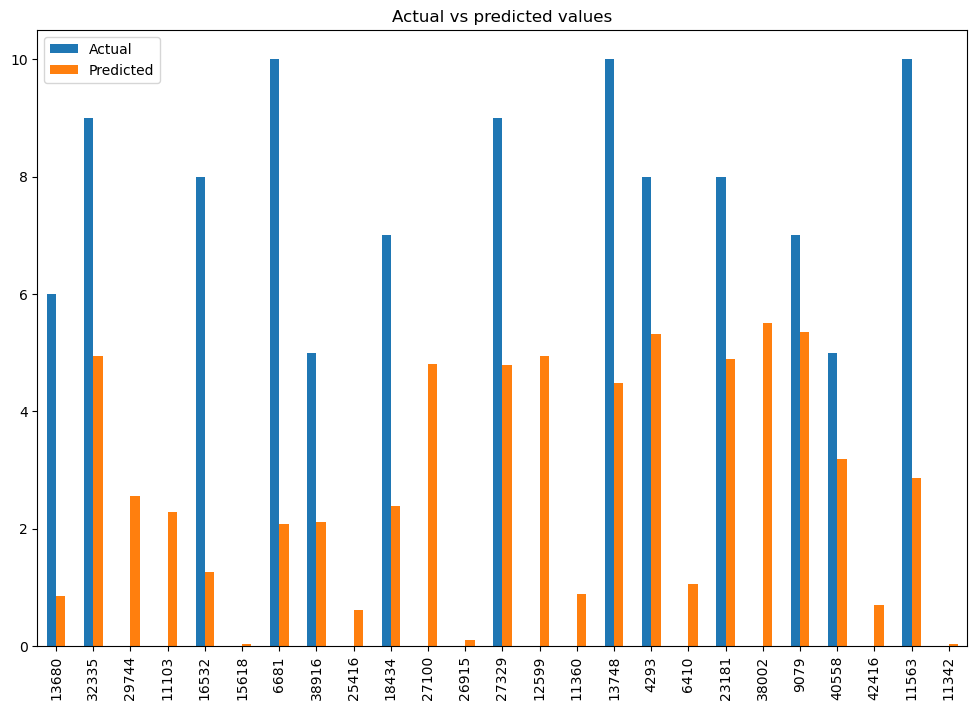

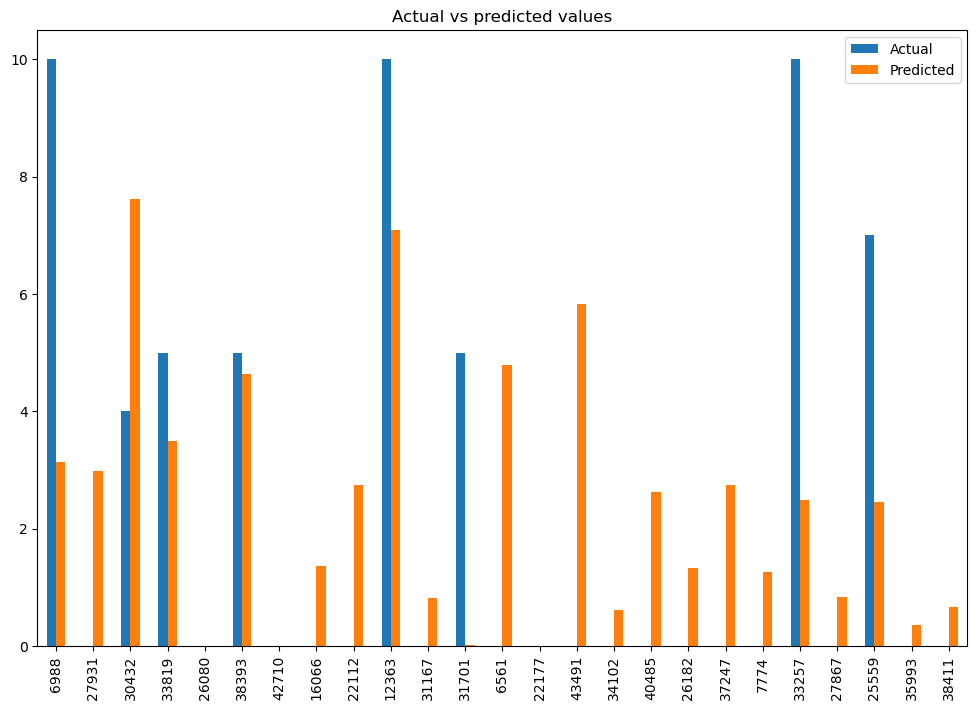

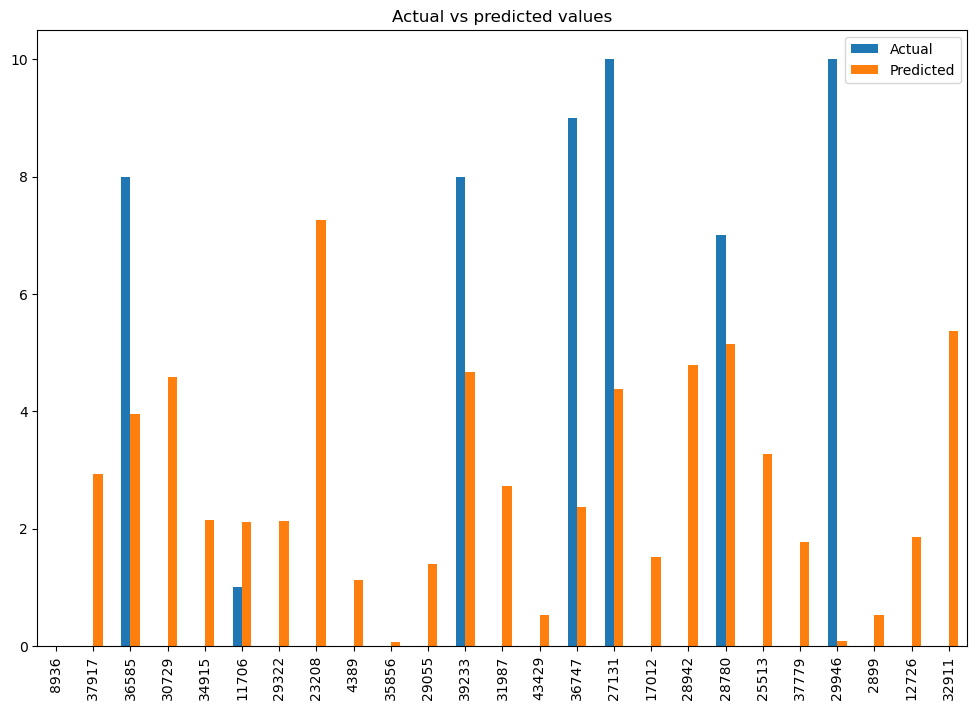

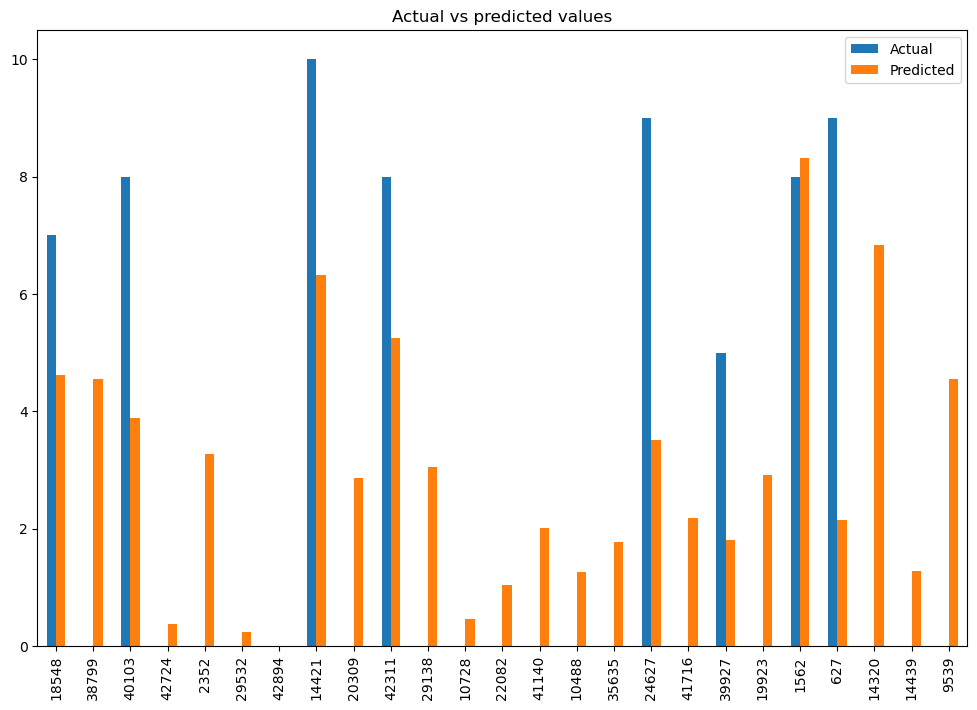

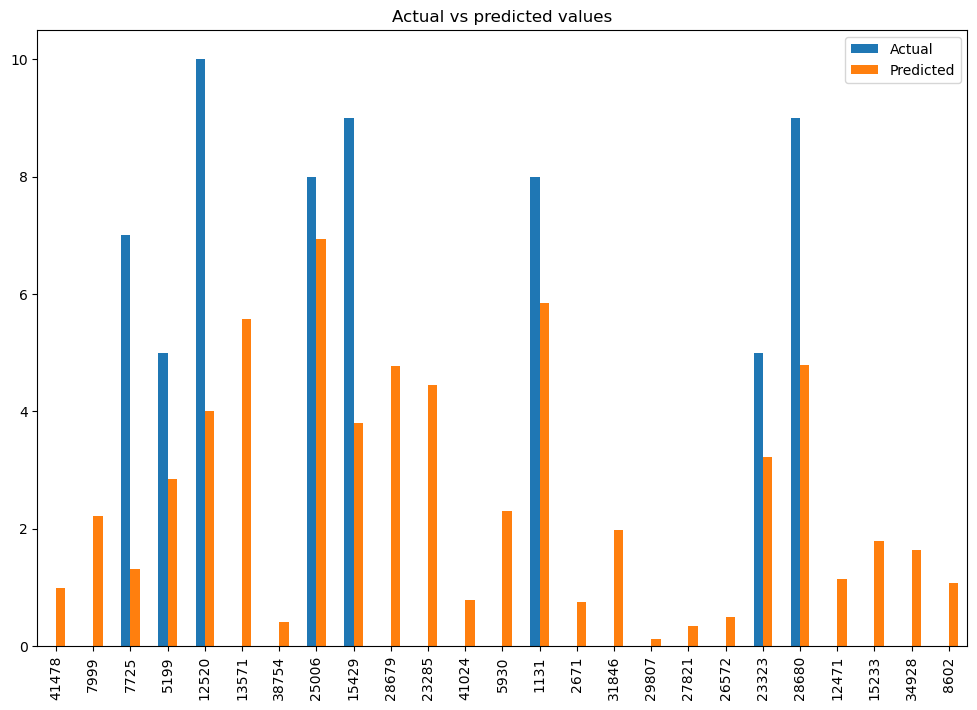

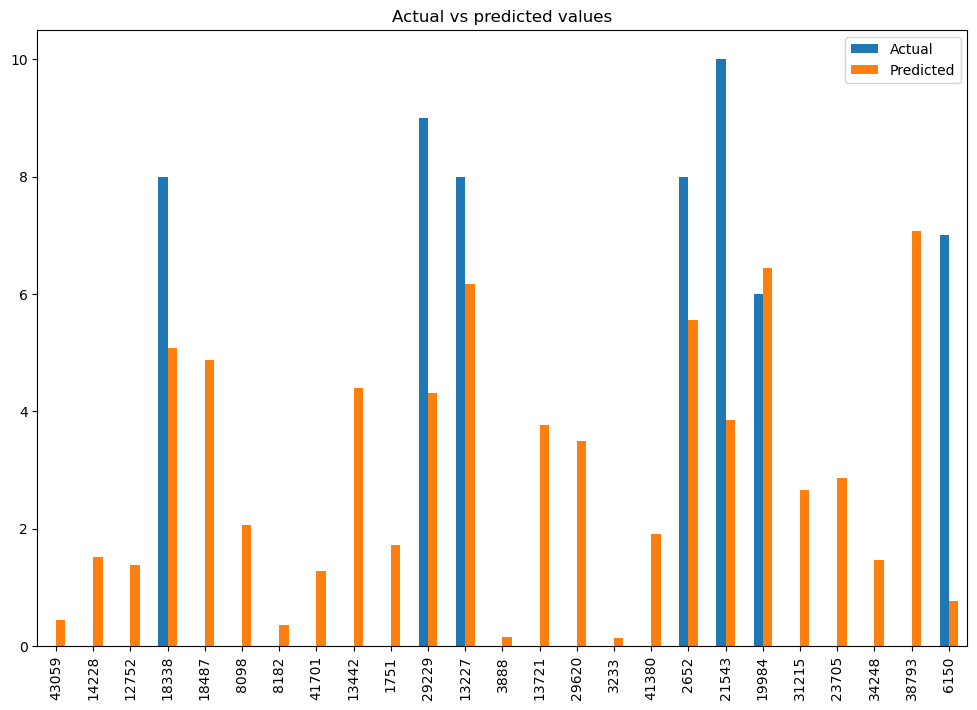

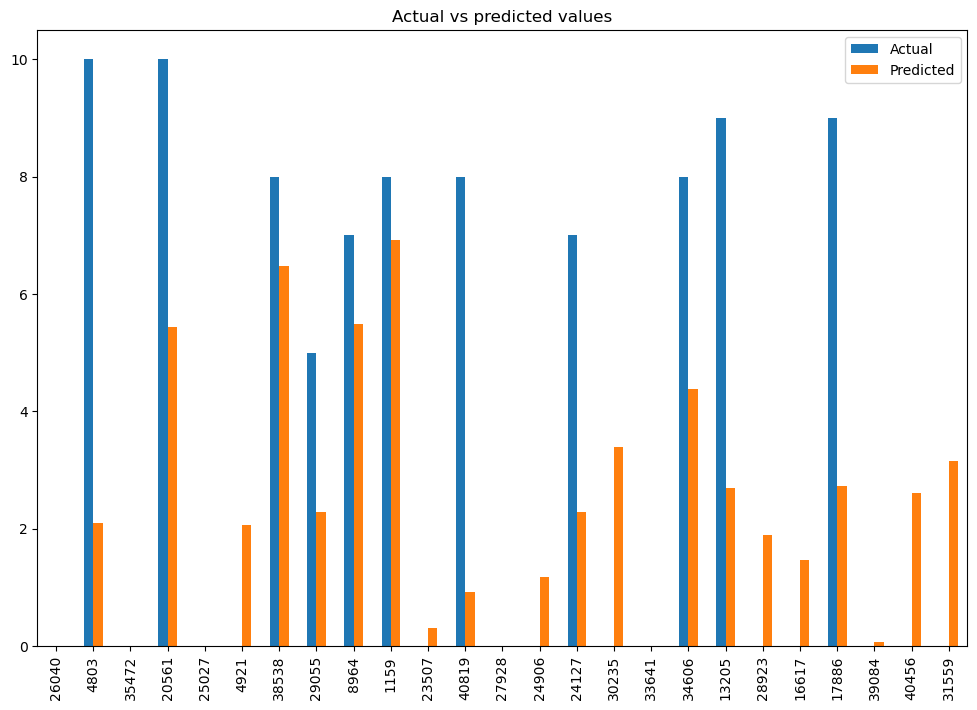

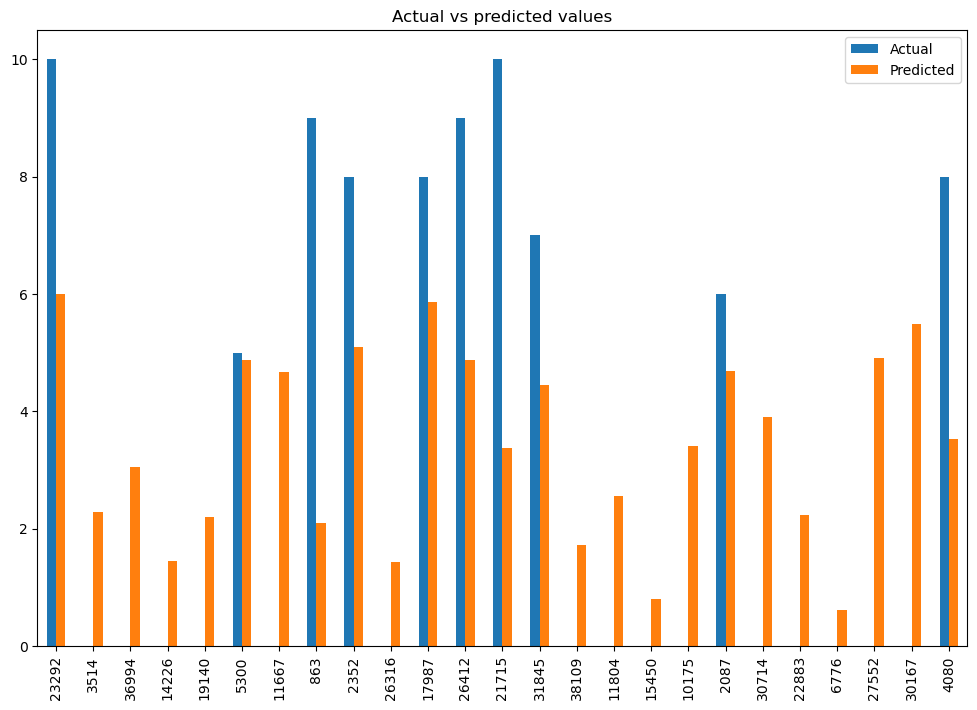

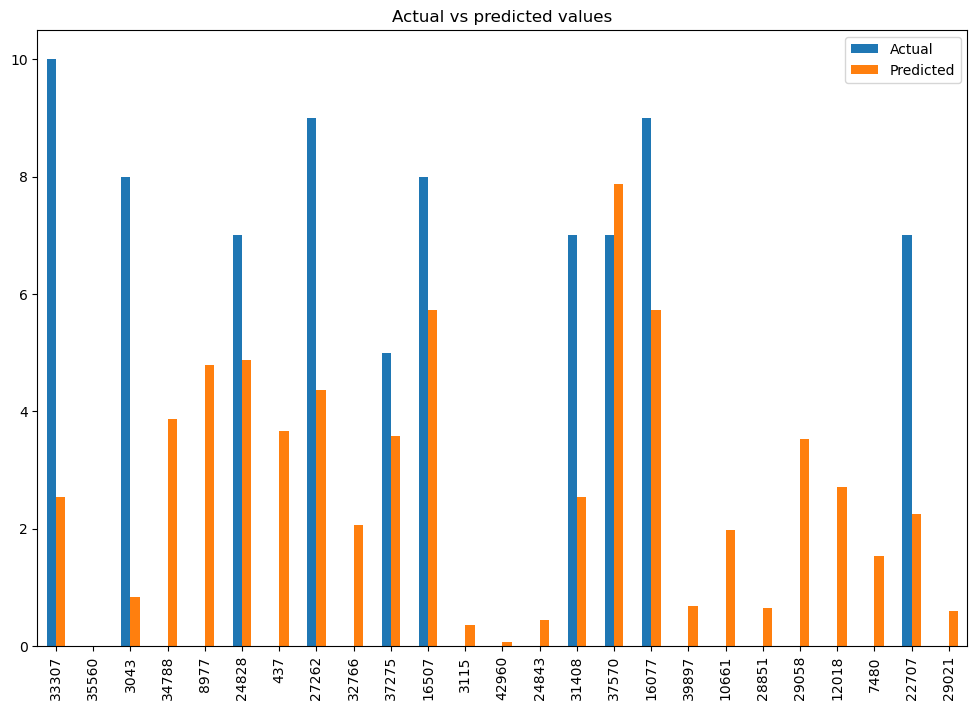

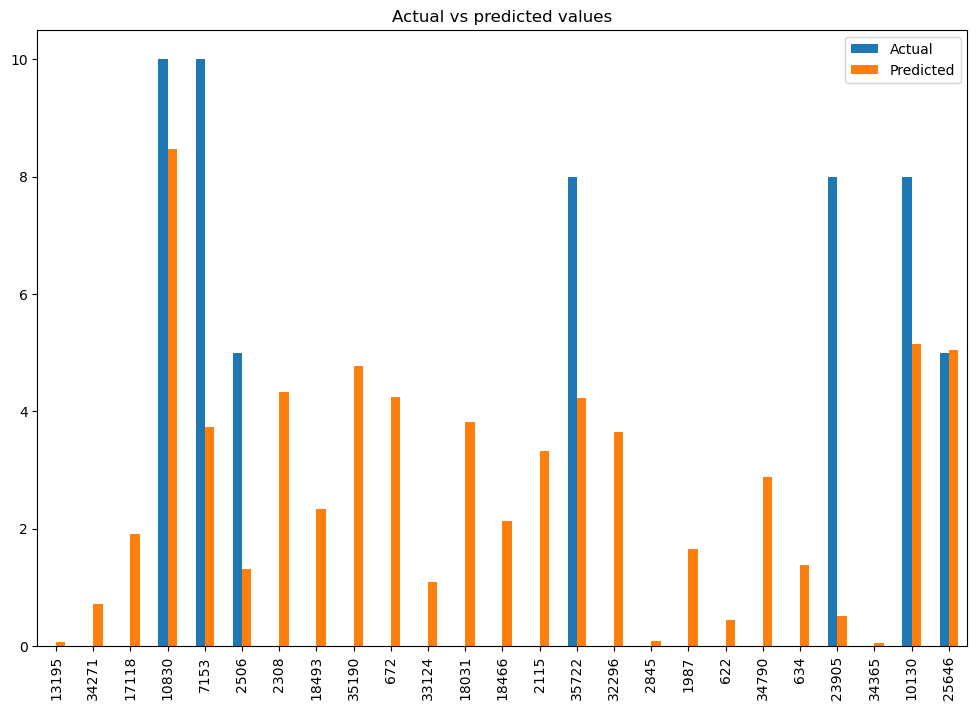

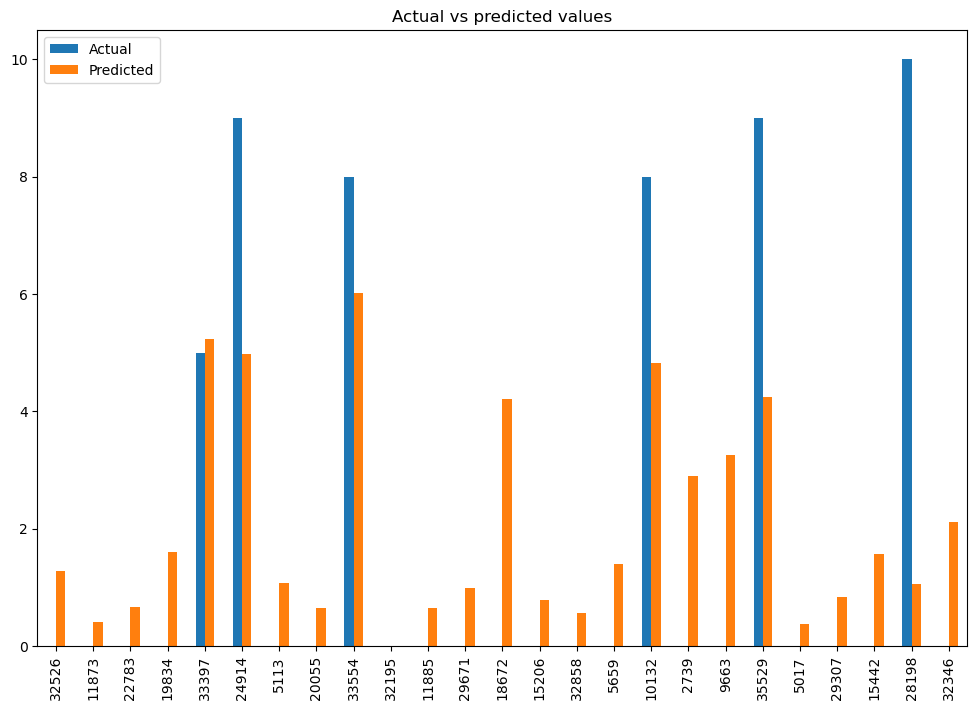

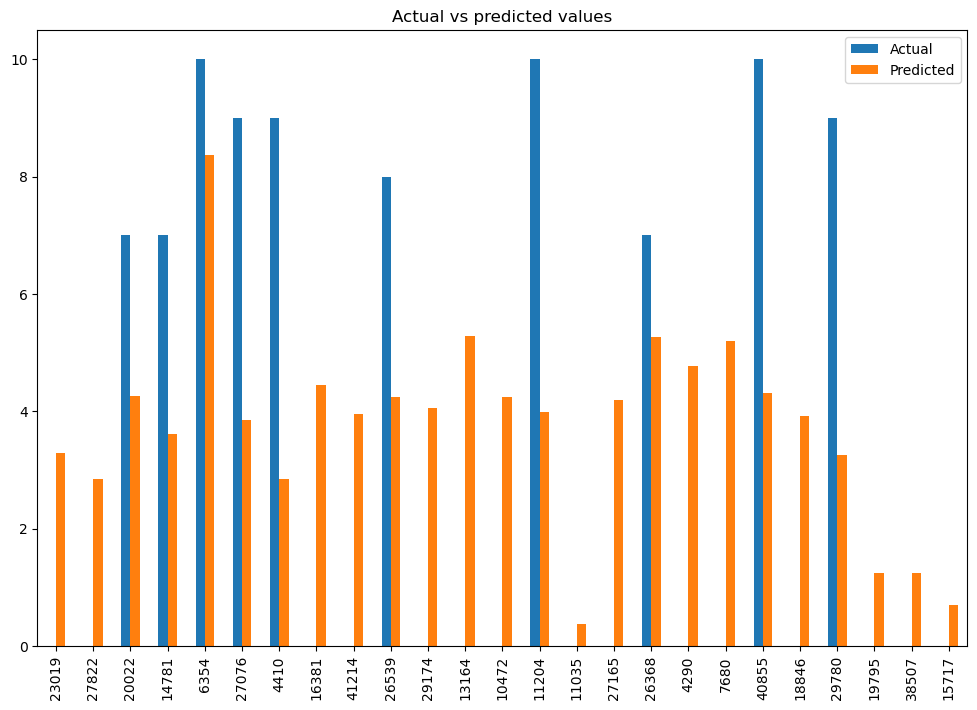

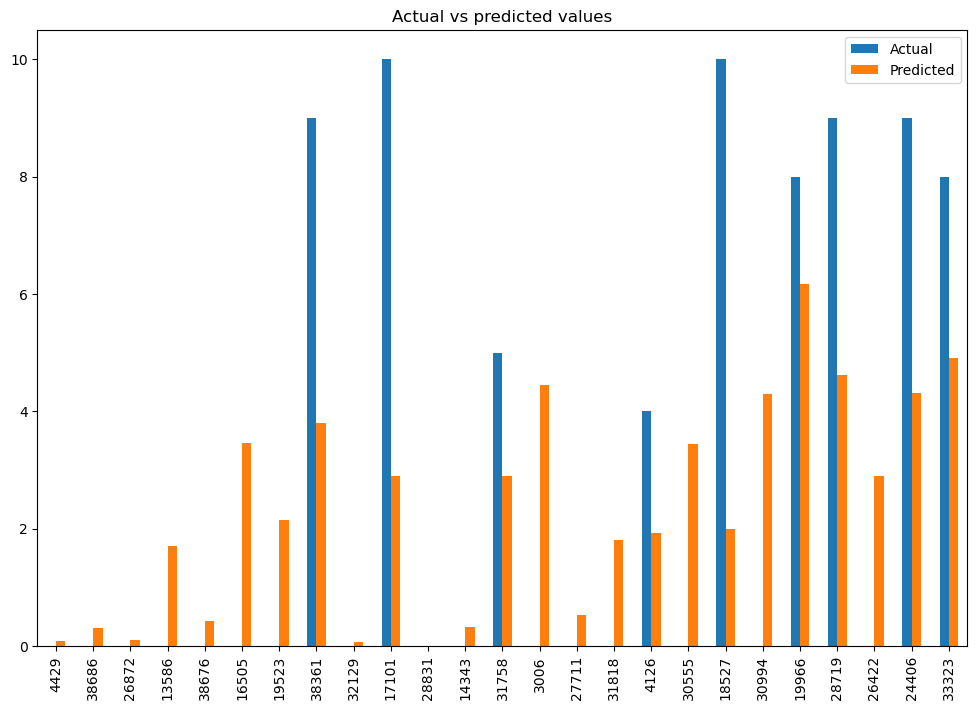

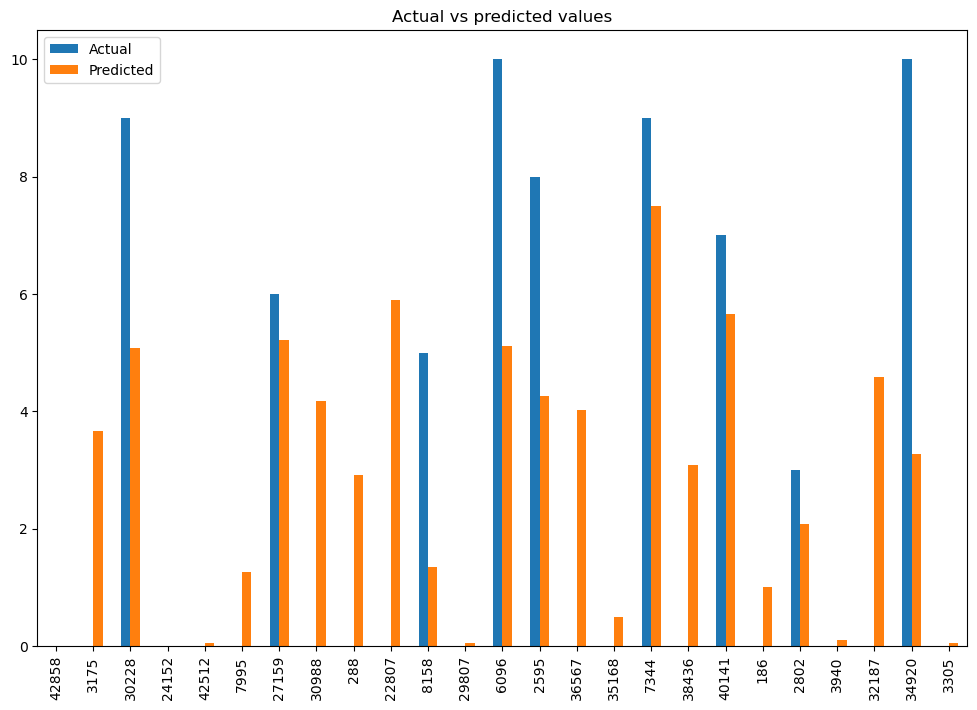

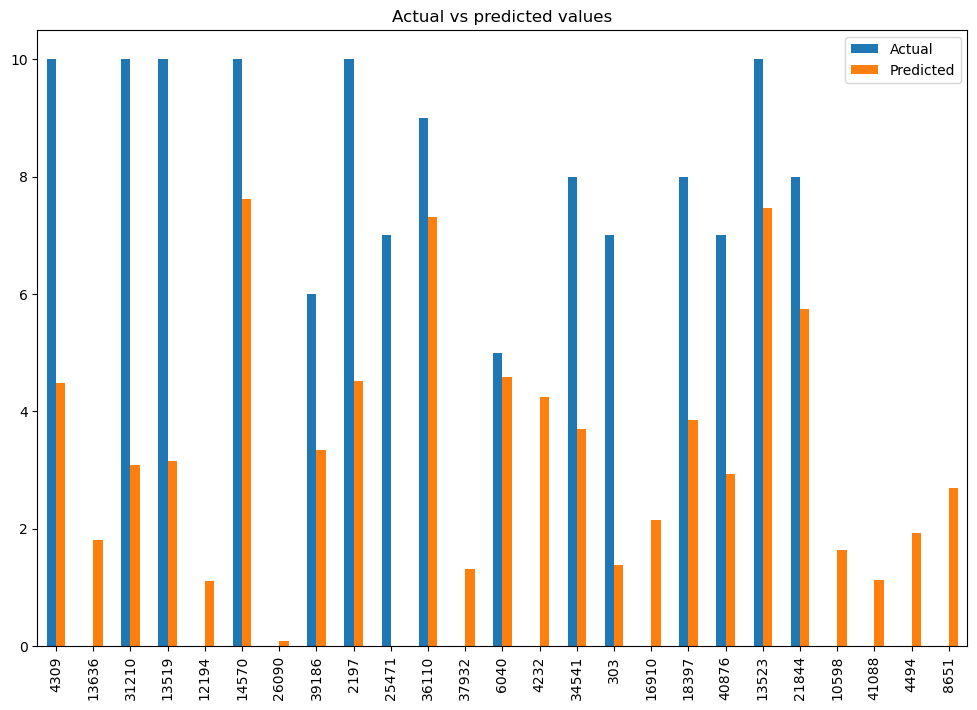

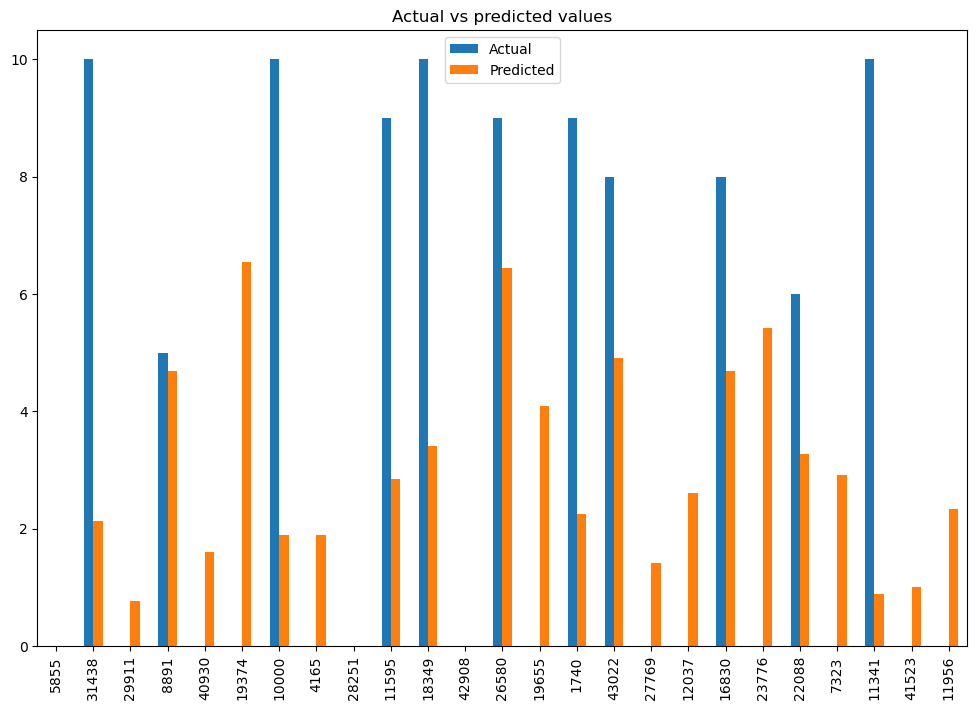

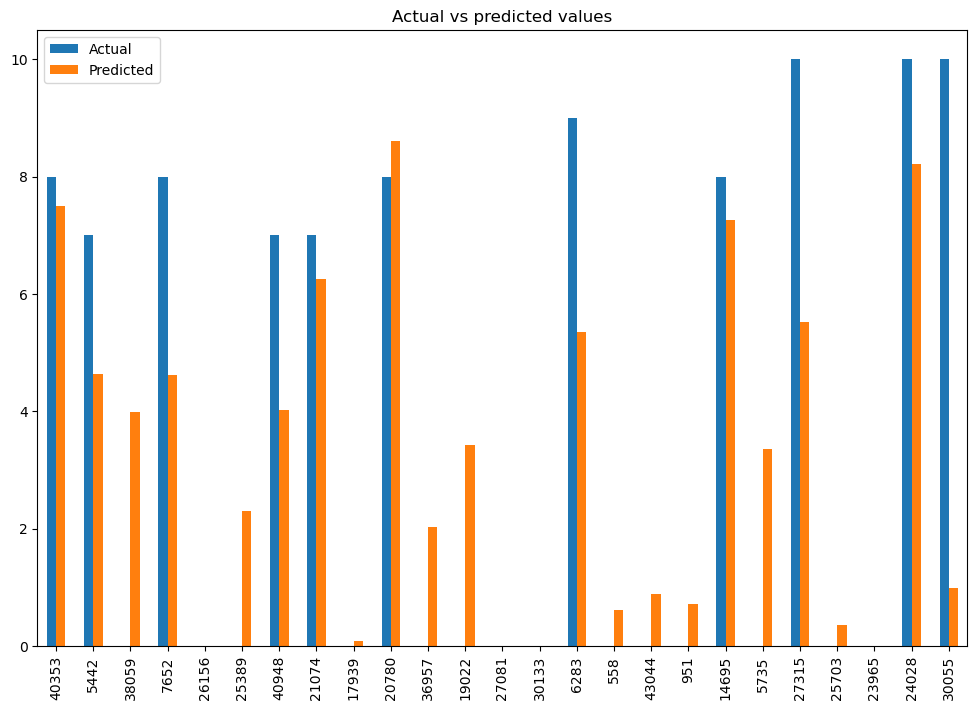

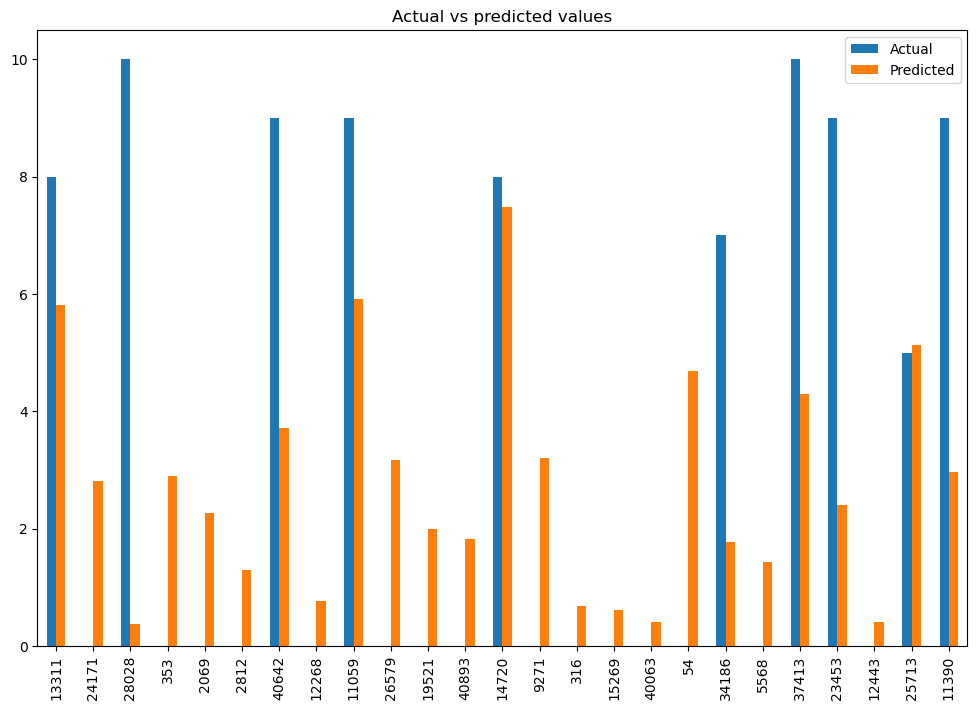

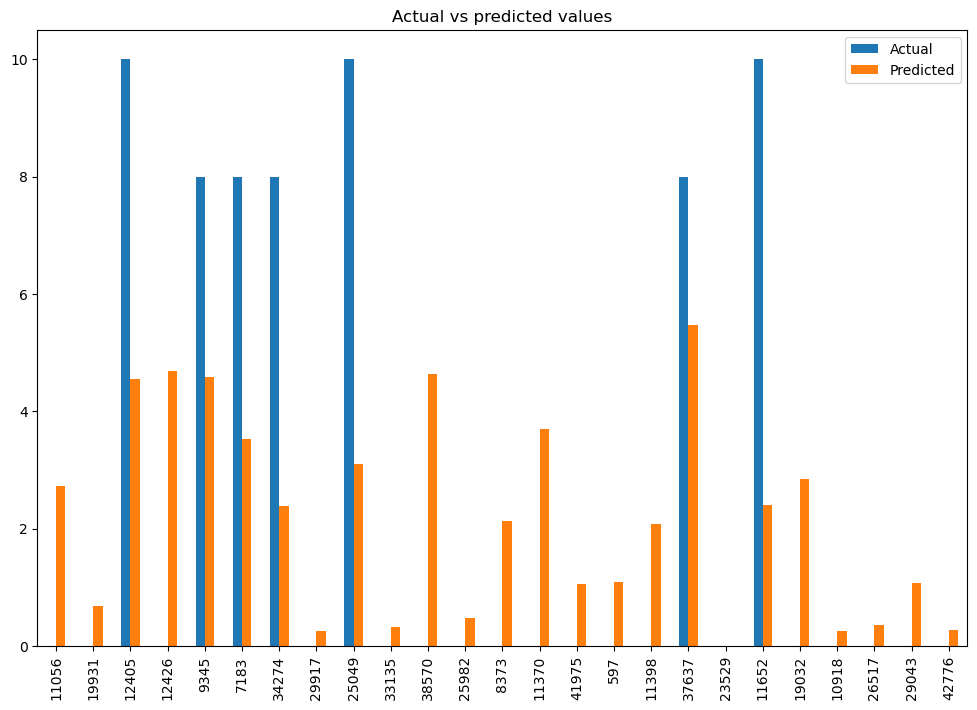

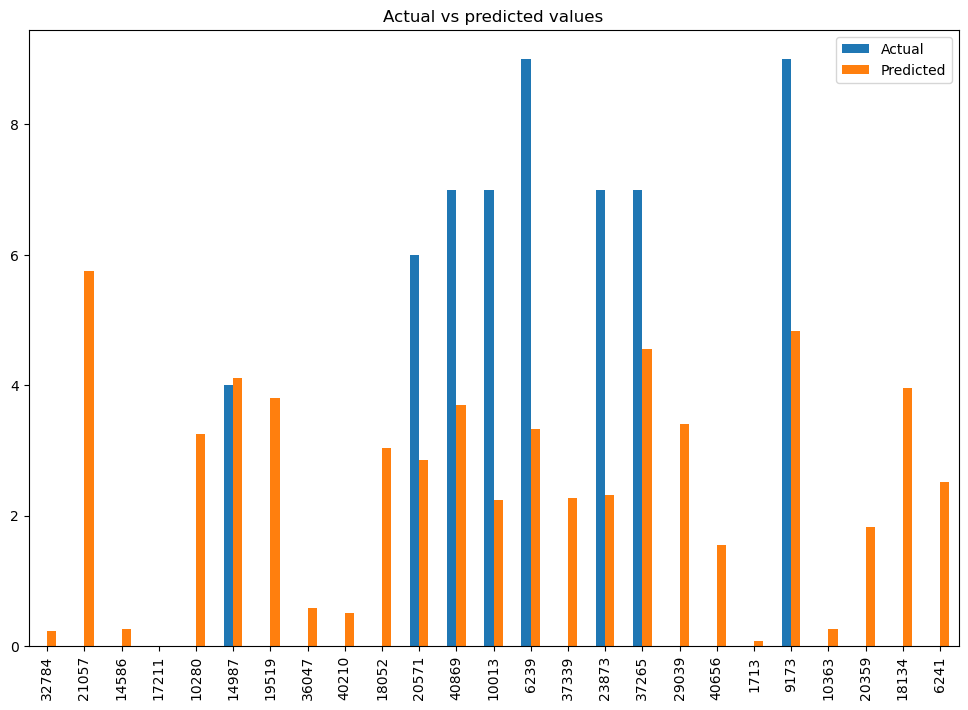

In [73]:
from sklearn.model_selection import KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold

k = 20 # a number of folds 
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=113)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from catboost import Pool

y_valid_pred = 0*y_train
y_test_pred = 0

FEATURE = ['User-ID', 'Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#, 'Topic_num']

for i, (train_index, test_index) in enumerate(skfold.split(X_train, y_train)):    
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
    X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')
    # OVER SAMPLING - SMOTE
    #smote_sample = SMOTE(random_state=113, sampling_strategy='minority') 
    #X_train_fold, y_train_fold = smote_sample.fit_resample(X_train_fold, y_train_fold)
    #X_valid_fold, y_valid_fold = smote_sample.fit_resample(X_valid_fold, y_valid_fold)
    
    train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=FEATURE)
    valid_pool = Pool(data=X_valid_fold, label=y_valid_fold, cat_features=FEATURE)

    
    print( "\nFold ", i)
    
    fit_model = model.fit(train_pool, 
                          eval_set=valid_pool,
                          use_best_model=True
                          )
    print( "  N trees = ", model.tree_count_ )
        

    def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
        y_pred = np.clip(model.predict(X_test),0,10)
        print(f"Test score: {r2_score(y_test, y_pred)}")
        print("MSE: ", mean_squared_error(y_test, y_pred))
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
        predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
        if show_plot == True:
            predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
            print(predictions_comparision.sample(10))    
    
    
        return {
            "test_score_r2" : r2_score(y_test, y_pred),
            "test_score_mse" : mean_squared_error(y_test, y_pred),
            "test_score_rmse" : np.sqrt(mean_squared_error(y_test, y_pred))
            }
    score_model(fit_model, X_train_fold, X_valid_fold, y_train_fold, y_valid_fold, show_plot=True)
    
    x_test[FEATURE] = x_test[FEATURE].astype('int')
    # Predict value Clipping
    y_test_pred +=  np.clip(fit_model.predict(x_test[X_valid_fold.columns]),0.0,10.0)
    
y_test_pred /= k  # Average test set predictions

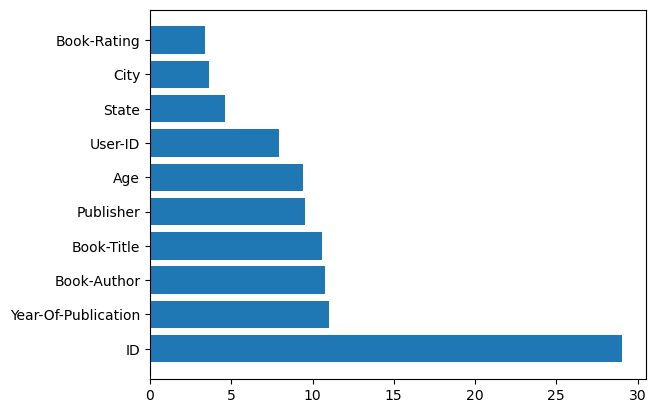

In [74]:
cat_importance_feature = np.argsort(model.feature_importances_)[:-31:-1]
plt.barh(train_lb.columns[cat_importance_feature], model.feature_importances_[cat_importance_feature])
plt.show()


In [75]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['Book-Rating'] = y_test_pred
sub

,ID,Book-Rating
0,TEST_000000,5.526231
1,TEST_000001,6.481341
2,TEST_000002,6.216493
3,TEST_000003,5.885997
4,TEST_000004,5.654919
...,...,...
159616,TEST_159616,3.667895
159617,TEST_159617,3.365036
159618,TEST_159618,4.027178
159619,TEST_159619,3.756423


<Axes: xlabel='Book-Rating', ylabel='Count'>

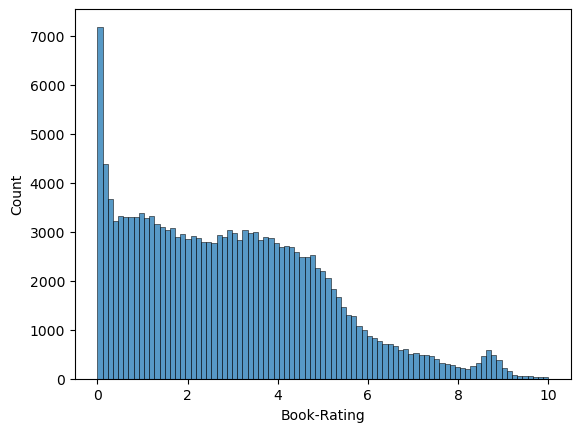

In [76]:
import seaborn as sns
sns.histplot(sub['Book-Rating'])

In [77]:
sub.to_csv('submit_cat+20-folds_scaler.csv', index=False,encoding="utf-8-sig")